<center><h1> Financial Reporting <h1></center>

> Introduction 

> Dans ce notebook, nous allons découvrir comment "automatiser" la création d'un reporting financier. 

>Le but ici est de réussir à se familiariser avec OpenPyxl et d'essayer d'avoir un code le plus clean possible malgré que l'on soit dans notebook.

<center><h3>La demande</h3></center>

Bonjour, 

J'ai besoin que tu prennes connaissance du fichier Excel [ci-joint](example/fichier_a_remplir.xlsx).

Tu trouveras dans l'onglet "Reporting" la liste des indicateurs à remplir. 

J'aimerai que tous les calculs soient faits avec Excel et que tu laisses les feuilles de calculs sur lesquelles tu as travaillé pour créer les indicateurs. 


### Commençons par importer les packages 

In [1]:
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(openpyxl.__version__)

3.1.3


Puis explorons les données pour nous familiariser avec 

In [2]:
# Lire le fichier Excel
df = pd.read_csv('data.csv', parse_dates=['date_adhesion'])
df

,client_id,type_client,date_adhesion,score,score_prev,id_agent,drc_complet
0,1,PP,1980-05-25 14:41:06,O,V,AUTO,False
1,2,PM,2001-11-25 10:36:55,V,R,AUTO,True
2,3,PP,2021-02-05 02:47:32,V,V,AUTO,True
3,4,PP,2013-08-14 02:45:04,V,V,AUTO,True
4,5,PP,1985-06-05 01:26:17,V,V,AUTO,True
...,...,...,...,...,...,...,...
24995,24996,PM,1988-10-25 17:45:37,V,V,AUTO,True
24996,24997,PM,2018-08-03 04:51:12,V,V,AUTO,True
24997,24998,PP,2014-09-16 16:31:19,V,O,AUTO,True
24998,24999,PM,2020-06-28 22:28:39,V,R,AUTO,True


### Inspectez les types de données

In [3]:
df.dtypes

client_id                 int64
type_client              object
date_adhesion    datetime64[ns]
score                    object
score_prev               object
id_agent                 object
drc_complet                bool
dtype: object

### Inspectez la présence de valeur manquantes

In [4]:
df.isna().sum()

client_id           0
type_client         0
date_adhesion       0
score            1326
score_prev       1412
id_agent            0
drc_complet         0
dtype: int64

### Analysez les variables disponibles 

Utilisez des counts, des tableaux croisés, des graphiques ... 

```python
df['type_client'].value_counts()
pd.crosstab(df['score'], df['score_prev'])
````


Première adhésion : 1980-01-01 10:03:16
Dernière adhésion : 2025-04-28 03:28:43

Répartition des scores :
score_prev     O     R      V    All
score                               
O            971   744   3021   4736
R            242   184    756   1182
V           3603  2532  10283  16418
All         4816  3460  14060  22336


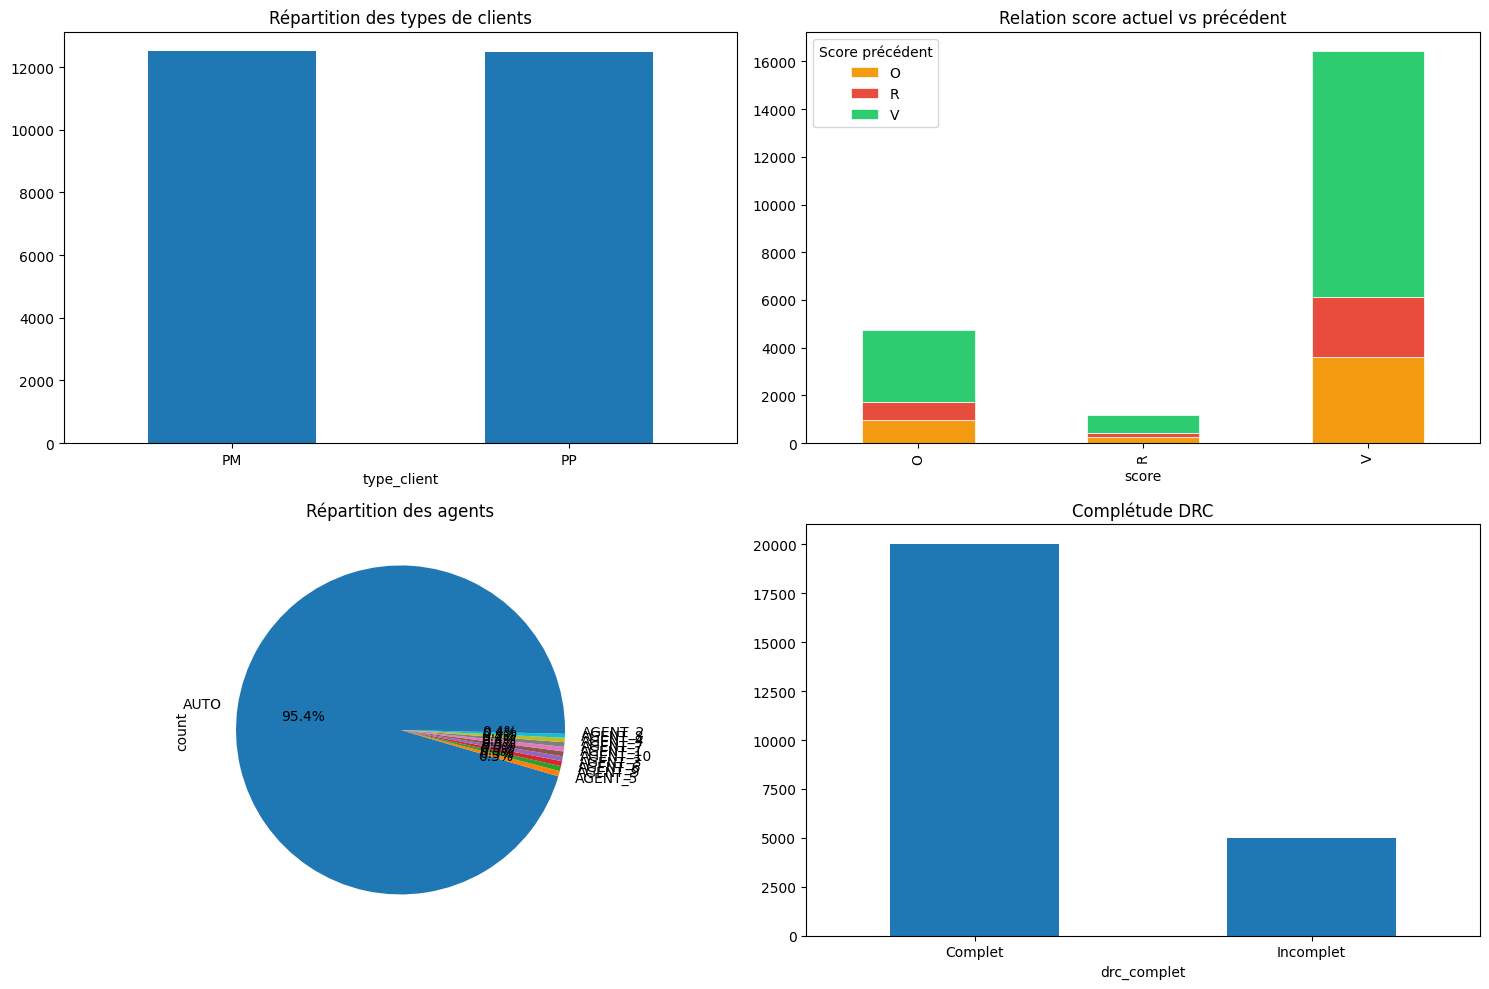

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Type de client
df['type_client'].value_counts().plot(kind='bar', ax=ax[0,0], title='Répartition des types de clients')
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=0)

# Analyse des scores
color_mapping = {
    'V': '#2ecc71',  # Vert
    'O': '#f39c12',  # Orange
    'R': '#e74c3c'   # Rouge
}
cross_tab = pd.crosstab(df['score'], df['score_prev'])
cross_tab.plot(kind='bar', 
               stacked=True,
               ax=ax[0,1],
               color=[color_mapping[col] for col in cross_tab.columns],  # Application du mapping
               title='Relation score actuel vs précédent',
               edgecolor='white',  # Contour blanc entre les segments
               linewidth=0.5)


ax[0,1].legend(title='Score précédent')

# Agent
df['id_agent'].value_counts().plot(kind='pie', ax=ax[1,0], autopct='%1.1f%%', 
                                 title='Répartition des agents')

# DRC Complet
df['drc_complet'].value_counts().plot(kind='bar', ax=ax[1,1], 
                                     title='Complétude DRC')
ax[1,1].set_xticklabels(['Complet', 'Incomplet'], rotation=0)

plt.tight_layout()

print(f"Première adhésion : {df['date_adhesion'].min()}")
print(f"Dernière adhésion : {df['date_adhesion'].max()}")

print("\nRépartition des scores :")
print(pd.crosstab(df['score'], df['score_prev'], margins=True))

### Remplissage du fichier

Pour remplir le fichier, nous allons créer plusieurs feuilles composées des données nécessaires à la création des indicateurs

In [6]:
from openpyxl import load_workbook
# Créer une nouvelle feuille Excel avec openpyxl
path_file = 'example/fichier_a_remplir.xlsx'


with pd.ExcelWriter(path_file, mode='a') as writer:
    df.to_excel(writer, sheet_name='DATA', index=False)

Nous pouvons maintenant passer à la création des indicateurs

In [7]:
# Il faut charger en mémoire le fichier 
wb = load_workbook(path_file)
# Puis récupérer la feuille
ws = wb['Indicateurs']

# On peut maintenant ajouter des formules
# 1. Nombre de clients PP 
ws['E8'] = '=COUNTIF(DATA!B:B, "PP")'

# 2. Nombre de clients PM
ws['E9'] = '=COUNTIF(DATA!B:B, "PM")'

wb.save(path_file)
wb.close()

Comme vous pouvez le voir, remplir ce fichier ne sera pas un soucis, c'est très simple de copier/coller la formule X fois en l'adaptant à la question. 

Je vous invite à prendre un peu de recul sur ce que vous faites et à chercher s'il n'existerait pas une solution plus adapté. 

Indices : data structures et fonctions.

In [13]:
def fill_indicators(path_file: str, data_sheet: str ='DATA') -> None:
    """
    Fill the indicators in the Excel file with formulas.

    Args:
        path_file (str): Path to the Excel file.
        data_sheet (str, optional): Name of the data sheet. Defaults to 'DATA'.
    """
    wb = load_workbook(path_file)
    ws = wb['Indicateurs']
    
    config = [
        # Répartition PP/PM
        {'row': 8, 'formule': 'COUNTIF', 'args': [('B', 'PP')]},
        {'row': 9, 'formule': 'COUNTIF', 'args': [('B', 'PM')]},
        {'row': 10, 'formule': 'SUM', 'args': ['E8:E9']},
        
        # Scores V/O/R
        {'row': 14, 'formule': 'COUNTIFS', 'args': [('B', 'PP'), ('D', 'V')]},
        {'row': 15, 'formule': 'COUNTIFS', 'args': [('B', 'PP'), ('D', 'O')]},
        {'row': 16, 'formule': 'COUNTIFS', 'args': [('B', 'PP'), ('D', 'R')]},
        {'row': 17, 'formule': 'CALCUL', 'args': 'E10 - (E14+E15+E16)'},
        
        # DRC Complet
        {'row': 22, 'formule': 'COUNTIFS', 'args': [('B', 'PP'), ('G', "VRAI")]},
        {'row': 23, 'formule': 'COUNTIFS', 'args': [('B', 'PM'), ('G', "VRAI")]},
        {'row': 24, 'formule': 'SUM', 'args': ['E22:E23']},
        
        # Focus V/O avec DRC
        {'row': 28, 'formule': 'COUNTIFS', 'args': [('B', 'PP'), ('D', 'V')]},
        {'row': 29, 'formule': 'COUNTIFS', 'args': [('B', 'PM'), ('D', 'V')]},
        {'row': 30, 'formule': 'SUM', 'args': ['E28:E29']},
    ]

    for item in config:
        cell = f'E{item["row"]}'
        
        if item['formule'] == 'COUNTIF':
            col, val = item['args'][0]
            ws[cell] = f'=COUNTIF({data_sheet}!{col}:{col}, "{val}")'
            
        elif item['formule'] == 'COUNTIFS':
            criteria = [f'{data_sheet}!{col}:{col}, "{val}"' for col, val in item['args']]
            ws[cell] = f'=COUNTIFS({", ".join(criteria)})'
            
        elif item['formule'] == 'SUM':
            ws[cell] = f'=SUM({item["args"][0]})'
            
        elif item['formule'] == 'CALCUL':
            ws[cell] = f'={item["args"]}'

    wb.save(path_file)
    wb.close()

# Utilisation
fill_indicators(path_file)